# Assignment 1 - Part 2

<div class="alert alert-block alert-warning">
    Below we import <a href="https://github.com/HIPS/autograd">autograd</a>. If you get an error saying you don't have it, you will need to install it with pip, using
<pre>
pip install autograd
</pre>
</div>

In [1]:
# I'm using PTable for making tables, so be sure to run this cell to check if you have PTable

import os

def import_or_install(name):
    try:
        __import__(name)
    except ImportError:
        os.system('pip install ' + name)

import_or_install("PTable")

from prettytable import PrettyTable

In [2]:
import  autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import jacobian, grad

## Newton's Method

We want to approximate solutions of nonlinear equation in __two variables__ using Newton's method.

Newton's method is implemented below.

Implement a stopping criterion. That is, given some tolerance $TOL$, end the method when $\mathbf{x}^k:=(x_1^k,x_2^k)$ satisfies $\|F(\mathbf{x}^k)\|_2\le TOL$ or $\|\mathbf{x}^{k+1}-\mathbf{x}^k\|_2\le TOL$.

Provide numerical evidence that your code works as it should by printing the values of $\|F(\mathbf{x}^k)\|_2$ for each iteration, and by making a plot of $\|F(\mathbf{x}^k)\|_2$, $\|\mathbf{x}^{k+1}-\mathbf{x}^k\|_2$, for all $k$.

Now, verify numerically the convergence is quadratic. You will need a reference solution, and one can do this in two ways:

 - Consider a problem for which you know an exact solution, and use said solution as a reference solution,
 - or for your problem, should you not know a solution, use the method to obtain an extremely accurate result which you use as a reference solution

In [3]:
def ooc(S):
    """
    Calculation of the order of a convergence of a convergent series.

    --Parameters--
    S: A list of NumPy-arrays
        The input list needs to have at least four elements for the method to succeed.
    
    --Returns--
    A float as the order of convergence of the series, or 0 if the function fails.
    """
    if (np.log(S[-2]/S[-3]) == 0) or (S[-2] == 0) or (S[-3] == 0):
        return 0
    if len(S) >= 3:
        return np.log(S[-1]/S[-2])/np.log(S[-2]/S[-3])
    return 0

In [4]:
def roc(S, q):
    """
    Finding a bound of the convergent error series

    --Parameters--
    S: A sequence

    --Side-effect--
    Shows a plot of this thing
    """
    ls = [S[i+1]/(S[i]**q) for i in range(len(S)-1)]
    print("Evolution of rate of convergence:")
    plt.figure()
    plt.plot(ls)
    plt.show()
    print("\n")

    return max(ls)

In [5]:
def newtonsMethod(F, x0, maxIter=100, TOL=1.0e-1000):
    """
    Implementation of Newton's root finding method.
    
    --Parameters--
    F: Function
        Numpy array of shape (2,) as input and output.
        This is the function we wish to find the root for
    x0: Numpy array of shape (2,).
        This is the initial guess for the method.
    maxIter: Integer
        The maximum number of iterations to do.
    TOL: Float
        The level of tolerance for when to stop the search
    """
    DF = jacobian(F) # Calculate the jacobian matrix of our function
    
    # Initialize variables before the for-loop 
    x1 = x0
    A, I, D, S = [], [], [], []
    
    for k in range(0, maxIter):
        x0 = x1
        J = DF(x0)
        Fx = F(x0)
        x1 = x0 - np.linalg.solve(J,Fx)
        A.append(x1) # Adding each iteration to A
        I.append(np.linalg.norm(Fx,2)) # Adding the norm of Fx to I
        D.append(np.linalg.norm(x1-x0,2)) # Adding the difference to D
        if ((D[-1]<=TOL) or (I[-1]<=TOL)) and (k > 3): break

    # Creating the error series
    for i in range(len(A)-1):
        S.append(np.linalg.norm(A[i]-A[-1])) # Adding the error to S

    print("Evolution of ||F(x)||:")
    plt.figure()
    plt.semilogy(I)
    plt.show()
    print("\n")

    print("Evolution of ||x1-x0||:")
    plt.figure()
    plt.semilogy(D)
    plt.show()
    print("\n")

    print("Evolution of error:")
    plt.figure()
    plt.plot(S)
    plt.show()
    print("\n")

    print(f"Rate of convergence:\nM >= {roc(S, 2)}\n")
    
    print(f"Order of convergence:\n{ooc(S)}\n")

    return x1

Evolution of ||F(x)||:


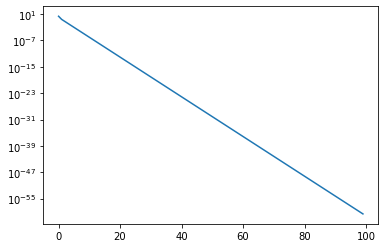



Evolution of ||x1-x0||:


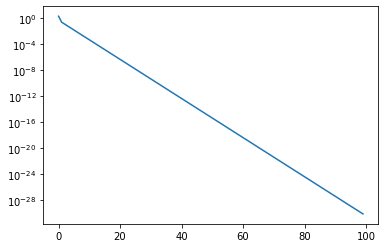



Evolution of error:


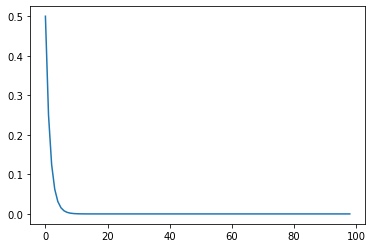



Evolution of rate of convergence:


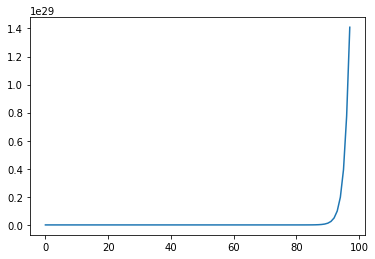



Rate of convergence:
M >= 1.4085006669202548e+29

Order of convergence:
1.2966069431192224

Zero:
[7.88860905e-31 0.00000000e+00]


In [6]:
# Test suite 1
f = lambda v: np.array([v[0]**2,v[1]])
print(f"Zero:\n{newtonsMethod(f, np.array([1.,2.]))}")

# I was unable to find an upper bound for the rate of convergence, but if I set the order to equals the calculated order, I will get an upper bound for this function

Evolution of ||F(x)||:


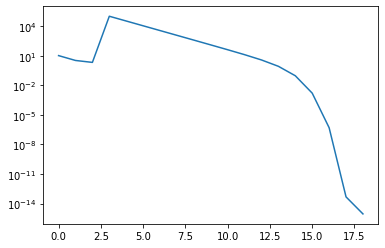



Evolution of ||x1-x0||:


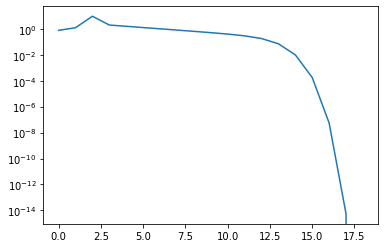



Evolution of error:


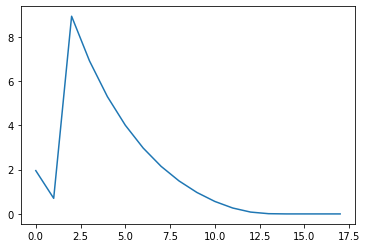



Evolution of rate of convergence:


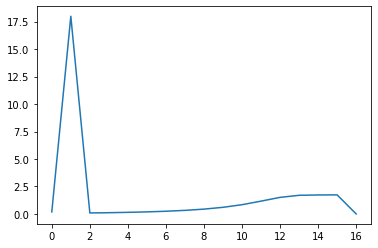



Rate of convergence:
M >= 17.98971967498433

Order of convergence:
inf

Zero:
[-1.15996226  1.        ]


In [7]:
# Test suite 2
g = lambda v: np.array([v[1]**3+v[0]**5+1.1,v[1]**2-1])
print(f"Zero:\n{newtonsMethod(g,np.array([1.,2.]))}")
# Here we can see that the calculated bound is real, therefore we have quadratic convergence. The calculation of the order failed though...

## Linear systems

Consider the linear system 
	\begin{equation*}
	A \mathbf{u} = \mathbf{f},
	\end{equation*}
where $A$ is a finite-difference discretization of the 2D Laplacian, this is a block tridiagonal matrix, implemented in the code below, and $\mathbf{f}$ is the vector with all components equal to one.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy import linalg
import time

# Creating the 2D laplacian matrix
def create2DLaplacian(nx, ny):
    N  = nx*ny
    main_diag = np.ones(N)*-4.0
    side_diag = np.ones(N-1)
    side_diag[np.arange(1,N)%4==0] = 0
    up_down_diag = np.ones(N-3)
    diagonals = [main_diag,side_diag,side_diag,up_down_diag,up_down_diag]
    laplacian = sparse.diags(diagonals, [0, -1, 1,nx,-nx])
    return laplacian*np.eye(N)

# Dummy matrix
test = create2DLaplacian(3,3)
print(test)

[[-4.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  1.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  1.  0.  0.  0.]
 [ 1.  0.  1. -4.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0. -4.  1.  0.  1.  0.]
 [ 0.  0.  1.  0.  1. -4.  1.  0.  1.]
 [ 0.  0.  0.  1.  0.  1. -4.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -4.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0. -4.]]


We will now approximate the solution of this linear system using some different iteration methods of the type 
	\begin{equation*}
		A_1 \mathbf{u}^{(k+1)} = A_2 \mathbf{u}^{(k)}+\mathbf{f},
	\end{equation*}
	where $A = A_1 - A_2$ with $|A_1|\ne0$. The way we choose the matrices $A_1$ and $A_2$ depends upon the method. We will use the following iterative methods to calculate approximate solutions to $\mathbf{u}$:

a) Jacobi ($A_1 = A_d$).

b) Forward Gauss-Seidel ($A_1 = A_d-A_l$).

c) Successive over relaxation ($A_1 = A_d-\omega A_l$, where you can choose the value of $\omega\in (0,1)$).

Here $A = A_d - A_l - A_u$, where

- $A_d$ is the diagonal of $A$,
- $A_l$ is $-$(strictly lower triangular part of $A$),
- $A_u$ is $-$(strictly upper triangular part of $A$).

Consider the residual vector $\mathbf{r}^k:=\mathbf{f}-A\mathbf{u}^k$. We fix $nx=ny=10$ and $N=100$. For each of the above, you should:

i) Compare the convergence of each method. Submit  a semi-log plot of the $2$-norm of the relative residual $\frac{ \|\mathbf{r}^k\|_2 }{ \| \mathbf{r}^0\|_2 }$ versus the number of iterations. Plot all the methods in the same plot for comparison.
Experiment choosing different values of $\omega$ in the SOR method, try to find a value that gives you optimal convergence for this problem.


ii) Implement a stopping criterion for the three methods as you have done for the Newton method. Record the relative time each method takes per iteration, and the rime needed to obtain a norm of the relative residual below toleances  $TOL=1e-7$ and $TOL=1e-14$. Make a table with the results for each method.

iii) Calculate the spectral radius of $A_1^{-1}A_2$ and see how that relates to convergence of the method. Make a semi-log plot for comparison. 

<div class="alert alert-block alert-info">
<b>Hint:</b> Python's 
    <pre>numpy.linalg.eigvals(A)</pre>
function returns the eigenvalues of $A$.
</div>

Note from student:
I realized after creating all of the different methods, that they are all special cases of the last method...

In [9]:
# The way I have solved these tasks is that I have implemented the functions to solve them beforehand, and then used the apropriate functions to solve the given task.
# This is the matrix to use for the final tests
toRun = create2DLaplacian(10,10)
print(toRun)

[[-4.  1.  0. ...  0.  0.  0.]
 [ 1. -4.  1. ...  0.  0.  0.]
 [ 0.  1. -4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -4.  1.  0.]
 [ 0.  0.  0. ...  1. -4.  1.]
 [ 0.  0.  0. ...  0.  1. -4.]]


In [10]:
# I hope the names of these functions are self-explanatory

def extractDiagonal(A):
    return np.diag(np.diag(A))

def extractLower(A):
    return -1*sparse.tril(A,-1)*np.identity(A.shape[0])

def extractUpper(A):
    return -1*sparse.triu(A,1)*np.identity(A.shape[0])

def getSpectralRadius(A):
    return np.linalg.norm(np.linalg.eigvals(A), np.inf)

In [11]:
def generalIteration(A, B, C, f, u0, maxIter, TOL):
    """
    The method of iteration used for the following problems

    --Parameters--
    A: NumPy Matrix
        This is the matrix denoted A
    B: NumPy Matrix
        This is the matrix denoted A1 inverse
    C: NumPy Matrix
        This is the matrix denoted A2
    f: NumPy Array
        f as the f from the problem
    u0: NumPy Array
        Initial guess
    maxIter: Integer
        The maximal iteration depth
    TOL: Float
        The level of tolerance between our approximation and the real solution

    --Returns--
    Returns a tuple of three things:
        1. The sequence created by the iteration
        2. The sequence of residues
        3. A list of time spent per iteration
    """
    # Setting up variables before loop
    u1 = u0
    Iter = [u0]
    TimeIter = []

    totNow = time.time() # Start "total" stopwatch 
    for i in range(maxIter):
        now = time.time() # Start "relative" stopwatch
        u0 = u1
        u1 = B @ (C @ u0 + f) # Calculate next element of sequence
        Iter.append(u1)
        if (np.linalg.norm(A@u1-f) <= TOL) or (np.linalg.norm(u1-u0) <= TOL) : 
            then = time.time() # End "relative" stopwatch
            TimeIter.append(then-now) # Add time taken to list
            break
        then = time.time() # End "relative" stopwatch
        TimeIter.append(then-now) # Add time taken to list
    totThen = time.time() # End "global" stopwatch

    return Iter, list(map(lambda x: f - A@x, Iter)), TimeIter, totThen - totNow

In [12]:
def jacobiMeth(A, f, u0, maxIter = 50, TOL = 1e-10, *args):
    """
    Implementation of Jacobis Method

    --Parameters--
    A: NumPy Matrix
        The A matrix from the problem
    f: NumPy Array
        The f vector from the problem
    u0: NumPy Array
        Initial guess
    maxIter: Integer
        Maximal iteration depth
    TOL: Float
        Level of Tolerance
    *args: A hack
        Has no purpose in this function, only to make another function function

    --Returns--
    Returns the arguments from the generalIteration function
    """
    # Initializing problem
    inv = lambda x: 1/x 
    A1Inv = np.diag(inv(np.diag(A))) # Since I know that A1 is diagonal, the inverse is quite easy to calculate
    A2 = extractDiagonal(A) - A

    specRad = getSpectralRadius(A1Inv@A2)
    out, res, relTimeIt, totTimeIt = generalIteration(A, A1Inv, A2, f, u0, maxIter, TOL)

    return out, res, relTimeIt, totTimeIt, specRad

In [13]:
def ForwardGSMeth(A, f, u0, maxIter = 50, TOL = 1e-10, *args):
    """
    Implementation of Forward Gauss-Seidel Method

    --Parameters--
    A: NumPy Matrix
        The A matrix from the problem
    f: NumPy Array
        The f vector from the problem
    u0: NumPy Array
        Initial guess
    maxIter: Integer
        Maximal iteration depth
    TOL: Float
        Level of Tolerance
    *args: A hack
        Has no purpose in this function, only to make another function function

    --Returns--
    Returns the arguments from the generalIteration function
    """
    # Initialize problem
    A1Inv = np.linalg.inv(extractDiagonal(A) - extractLower(A))
    A2 = extractUpper(A)

    specRad = getSpectralRadius(A1Inv @ A2)
    out, res, relTimeIt, totTimeIt = generalIteration(A, A1Inv, A2, f, u0, maxIter, TOL)

    return out, res, relTimeIt, totTimeIt, specRad

In [14]:
def SuccessOverRelaxMeth(A, f, u0, maxIter = 50, TOL = 1e-10, *args):
    """
    Implementation of the Success over relaxation Method

    --Parameters--
    A: NumPy Matrix
        The A matrix from the problem
    f: NumPy Array
        The f vector from the problem
    u0: NumPy Array
        Initial guess
    maxIter: Integer
        Maximal iteration depth
    TOL: Float
        Level of Tolerance
    *args: A hack
        The first element of args is assigned to be w. If no element has been provided, fall back to 0.5

    --Returns--
    Returns the arguments from the generalIteration function
    """
    # Initialize problem
    if len(list(args)) == 0:
        w = 0.5
    else:
        w = args[0]
    A1Inv = np.linalg.inv(extractDiagonal(A) - w*extractLower(A))
    A2 = (1-w)*extractLower(A) + extractUpper(A)

    specRad = getSpectralRadius(A1Inv @ A2)
    out, res, relTimeIt, totTimeIt = generalIteration(A, A1Inv, A2, f, u0, maxIter, TOL)

    return out, res, relTimeIt, totTimeIt, specRad

In [15]:
def randomVec(n, reach):
    """
    Creating a random vector

    --Parameters--
    n: Integer
        Dimension of the vector
    reach: Float
        the values of each element in the vector is within the interval (-reach,reach)

    --Returns--
    Returns a vector of dimension n with random entries.
    """
    np.random.seed()
    v = np.random.rand(n)
    trans = lambda x: 2*reach*(x-1/2)
    return trans(v)

In [16]:
def testIteration(Iterative, initVal = False, A = test, f = randomVec(9, 10), u0 = randomVec(9, 10), maxIter = 50, TOL = 1e-10, *args):
    """
    Implementation of a random test generator

    --Parameters--
    Iterative: Function
        This is which iteration method as defined above should be used
    A: NumPy Matrix
        The matrix given as A
    f: NumPy Array
        The f vector from the problem
    u0: NumPy Array
        Initial guess
    maxIter: Integer
        Maximal iteration depth
    TOL: Float
        Level of Tolerance
    *args: A hack

    --Returns--
    Returns a tuple of four things:
        1. The order of convergence
        2. The average iteration time
        3. the average norm-calculation time
        4. The level of tolerance
    """
    out, res, relTimeIt, totTimeIt, specRad = Iterative(A, f, u0, maxIter, TOL, *args)

    if initVal:
        print(f"u0:\n{u0}")
        print(f"f:\n{f}")
        print(f"Solution:\n{out[-1]}")

    relRes = []
    diffTime = []

    totNow = time.time() # Start "total" stopwatch
    
    for x in res:
        now = time.time()
        relRes.append(np.linalg.norm(x)/np.linalg.norm(res[0]))
        then = time.time()
        diffTime.append(then-now)

    totThen = time.time() # Stop "total" stopwatch
    totDiffTime = totThen - totNow 

    diffRes = [relRes[i+1]/relRes[i] for i in range(1, len(relRes)-1)]

    avgItTime = sum(relTimeIt)/len(relTimeIt)
    avgDiffTime = sum(diffTime)/len(diffTime)

    return diffRes[-1], specRad, avgItTime, avgDiffTime, TOL, relRes

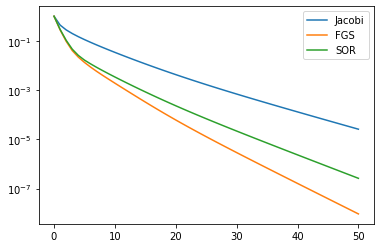

In [17]:
# This is part one of the solution to taks i)
def rankResidues(A, w=0.7, printable = False):
    """
    A function which makes a plot of the relative residues from the different methods
    It generates a random f and creates a random guess, to randomize the test

    --Parameter--
    A - NumPy Matrix
        The matrix to use a base for the iteration problem

    --Side-effect--
    Prints a plot of the residues

    --Returns--
    A tuple of the residues
    """

    f, u = randomVec(100, 10), randomVec(100, 10)
    methods = [jacobiMeth, ForwardGSMeth, SuccessOverRelaxMeth]
    names = ["Jacobi", "FGS", "SOR"]

    pilates = [testIteration(meth, False, A, f, u, 50, 1e-10, w)[-1] for meth in methods]

    for i in range(len(names)):
        pilates[i] = (names[i], pilates[i])

    if printable:
        plt.figure()
        for el in pilates:
            plt.semilogy(el[1], label = el[0])
        plt.legend()

    return pilates

hack = rankResidues(toRun, True) # Need to bind the output, so that jupyter won't print it

Smallest at: 1.3766233766233766


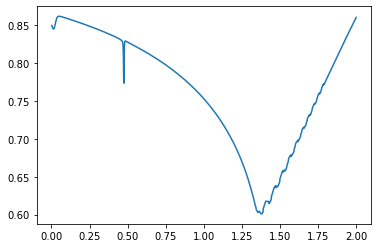

In [32]:
# This is part two of the solution of i)
def optimalSOR(fineness, A, f, u, printable = False):
    """
    A test for finding different convergence rates for the SOR-method

    --Parameters--
    fineness - Integer
        How many steps the graph should take
    A - NumPy Matrix
        iteration problem matrix
    f - NumPy Array
        iteration problem vector
    u - NumPy Array
        initial guess
    printable - Bool
        If it should print the graph or not print the graph

    --Side-effect--
    Prints a plot of the graph

    --Returns--
    Returns all the statistics from the SOR-tests
    """
    somethingsomething = [2*i/(fineness+1) for i in range(1, (fineness+1))]
    tests = [testIteration(SuccessOverRelaxMeth, False, A, f, u, 100, 1e-10, 2*i/(fineness+1)) for i in range(1,(fineness+1))]
    if printable:
        plt.figure()
        plt.plot(somethingsomething, [el[0] for el in tests])

    return somethingsomething, tests


f, u = randomVec(100, 10), randomVec(100, 10)

smol = (0, 1)

somethingsomething, tests = optimalSOR(1000, toRun, f, u, True)
pairing = [(somethingsomething[i], tests[i][0]) for i in range(len(tests))]
for tup in pairing:
    if tup[1] < smol[1]: smol = tup

print(f"Smallest at: {smol[0]}")

In [20]:
# Solution of ii)
def rankMethods(A, w=0.5, printable = False):
    """
    A function which makes a table of statistics from the different methods
    It generates a random f and creates a random guess, to randomize the test

    --Parameter--
    A - NumPy Matrix
        The matrix to use a base for the iteration problem

    --Side-effect--
    Prints a table of the statistics

    --Returns--
    The list of the statistics
    """

    f, u = randomVec(100, 10), randomVec(100, 10)
    methods = [jacobiMeth, ForwardGSMeth, SuccessOverRelaxMeth]
    names = ["Jacobi", "FGS", "SOR"]
    tolerances = [1e-7, 1e-14]
    others = [list(testIteration(meth, False, A, f, u, 1000, tol, w)[:-1] for tol in tolerances for meth in methods]

    for i in range(len(others)):
        others[i].insert(0, names[i%3])

    if printable:
        x = PrettyTable()

        x.field_names = ["Method Name", "Rate of Convergence", "Spectal Radius", "Average Iteration time", "Average Norm Time", "Tolerance"]

        for el in others:
            x.add_row(el)

        print(x)

    return others

hack = rankMethods(toRun, True) # Need to bind the output, so that jupyter won't print it

+-------------+---------------------+--------------------+------------------------+------------------------+-----------+
| Method Name | Rate of Convergence |   Spectal Radius   | Average Iteration time |   Average Norm Time    | Tolerance |
+-------------+---------------------+--------------------+------------------------+------------------------+-----------+
|    Jacobi   |  0.8519606236112163 | 0.8650653134026233 | 0.0002735884843674381  | 8.746197349146792e-06  |   1e-07   |
|     FGS     |  0.7527183682342101 | 0.7526561945006798 | 0.0002216195303296286  | 1.5582889318466187e-05 |   1e-07   |
|     SOR     |  0.8270968089574494 | 0.8270596956759886 | 0.00024353626162506813 | 1.1463274900940643e-05 |   1e-07   |
|    Jacobi   |  0.8881350461991575 | 0.8650653134026233 | 0.00023439842435072096 | 4.573699531205204e-06  |   1e-14   |
|     FGS     |  0.8260823534288397 | 0.7526561945006798 | 0.00022628928432945445 |  8.30690066019694e-06  |   1e-14   |
|     SOR     |  0.8380138985979

In [19]:
def compareConvSpec(A, method, f = randomVec(100, 10), u = randomVec(100, 10), w=0.5, printable = False):
    """
    A function which compares the Rate of Convergence to the Spectral Radius
    The SOR method has w = 0.5 for all tests

    --Parameters--
    A - NumPy Matrix
        Defining matrix for the iteration method

    method - Function
        The iteration method to use

    --Side-Effects--
    Prints the rate of convergence alongside its spectral radius

    --Returns--
    Returns the statistics for the test
    """
    subject = testIteration(method, False, A, f, u, 1000, 1e-10, w)

    if printable: print(f"Rate of convergence: {subject[0]}\nSpectralradius: {subject[1]}")

    return subject

Jacobi
-------------------------------------------------
Rate of Convergence: 0.8574499272001328
Spectral Radius: 0.8650653134026233

FGS
-------------------------------------------------
Rate of Convergence: 0.7526054824598072
Spectral Radius: 0.7526561945006798

SOR - w = 1.3766233766233766
-------------------------------------------------
Rate of Convergence: 0.8270523953311054
Spectral Radius: 0.8270596956759886



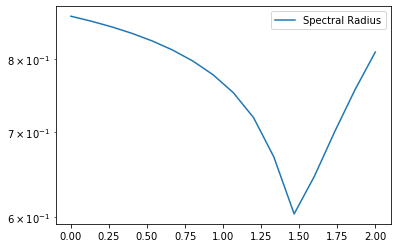

In [34]:
def rankSpec(fineness, A, w, printable = False):
    f, u = randomVec(100, 10), randomVec(100, 10)

    methods = [jacobiMeth, ForwardGSMeth, SuccessOverRelaxMeth]
    names = ["Jacobi", "FGS", f"SOR - w = {w}"]
    tests = [compareConvSpec(toRun, methods[i], f, u) for i in range(len(methods))]

    _, sors = optimalSOR(15, toRun, f, u)
    plotlist = [tests[0][1]]

    for el in sors:
        plotlist.append(el[1])

    if printable:    
        for i in range(len(methods)):
            print(f"{names[i]}")
            print("-------------------------------------------------")
            print(f"Rate of Convergence: {tests[i][0]}\nSpectral Radius: {tests[i][1]}\n")
        
        # print(plotlist) # There is something strange with this plot
    
        scalelist = list(np.arange(0,2,2/(len(plotlist)-1)))
        scalelist.append(2.)

        plt.figure()
        plt.semilogy(scalelist, plotlist, label = "Spectral Radius")
        plt.legend()

rankSpec(15, toRun, smol[0], True)